In [2]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 70

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:
    """
    A class that represents a value in a computation graph with support for automatic differentiation.
    
    Attributes:
    -----------
    data : float
        The actual value of the computation.
    grad : float
        The gradient of the value, used during backpropagation.
    label : str
        An optional label for the value, useful for visualization or debugging.
    _backward : function
        A function to compute the gradient of the value with respect to its inputs.
    _prev : set
        A set of parent nodes (i.e., inputs) in the computation graph.
    _op : str
        The operation that produced this value (e.g., '+', '*', 'tanh').
    """
    
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __radd__(self, other) -> 'Value':
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other) -> 'Value':
        return self + (-other)
    
    def __mul__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other) -> 'Value':
        return self * other

    def __pow__(self, other) -> 'Value':
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other -1) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other) -> 'Value':
        out = self * other**-1

        return out

    def tanh(self) -> 'Value':
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self) -> 'Value':
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out

    def backward(self) -> None:
        topological_order = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topological_order.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topological_order):
            node._backward()

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# weighter sum
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# squishification function
o = n.tanh(); o.label = 'o'

o.backward()

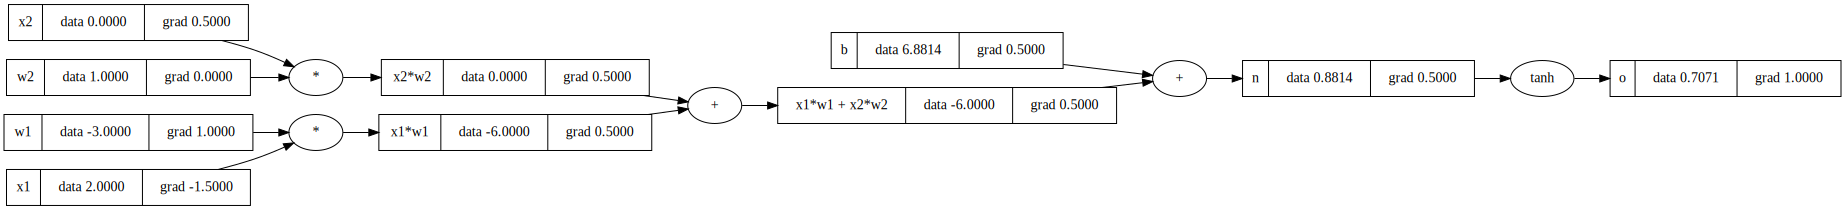

In [5]:
draw_dot(o)

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# weighter sum
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# squishification function
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()

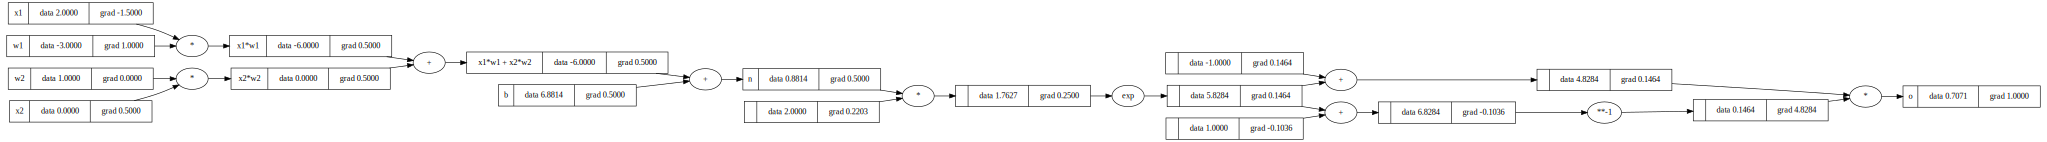

In [7]:
draw_dot(o)

In [8]:
import torch

In [9]:
# pytorch implementation
x1 = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.float64, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.float64, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
b = torch.tensor([6.8813735870195432], dtype=torch.float64, requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()
print('--------')
print(f"x1: {x1.grad.item()}\nx2: {x2.grad.item()}\nw1: {w1.grad.item()}\nw2: {w2.grad.item()}")  

0.7071067811865476
--------
x1: -1.4999999999999998
x2: 0.49999999999999994
w1: 0.9999999999999999
w2: 0.0


In [10]:
class Neuron:
    def __init__(self, number_of_inputs) -> None:
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(number_of_inputs)] # vector of input weights
        self.b = Value(np.random.uniform(-1, 1)) # bias

    def __call__(self, inputs):
        weighted_sum = sum((w_i*x_i for w_i, x_i in zip(self.w, inputs)), self.b)
        activation = weighted_sum.tanh()

        return activation
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, number_of_inputs, number_of_outputs) -> None:
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_outputs)]

    def __call__(self, input):
        outputs = [neuron(input) for neuron in self.neurons]

        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, number_of_inputs, number_of_outputs_list) -> None:
        size = [number_of_inputs] + number_of_outputs_list
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(number_of_outputs_list))]

    def __call__(self, vector):
        for layer in self.layers:
            vector = layer(vector)

        return vector

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# input layer: 3 "neurons"
# hidden layer 1: 4 neurons
# hidden layer 2: 4 neurons
# output layre: 1 neuron
input = [2.0, 3.0, -1.0]
mlp = MLP(len(input), [4, 4, 1])
outputs = mlp(input)

In [11]:
training_set = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

labels = [1.0, -1.0, -1.0, 1.0]
predictions = [mlp(input) for input in training_set]
predictions

[Value(data=0.9596559343735493),
 Value(data=0.03631361869432056),
 Value(data=0.4489187055158661),
 Value(data=0.8996519230396443)]

In [12]:
for k in range(80):
    # forward pass
    predictions = [mlp(input) for input in training_set]
    loss = sum((y_prediction - y_ground_truth)**2 for y_ground_truth, y_prediction in zip(labels, predictions))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0 # zero_grad
    loss.backward()

    for p in mlp.parameters():
        p.data += -0.5 * p.grad # gradient descent
    
    print(k, loss.data)


0 3.1850087116660033
1 3.275030548065448
2 0.032157800794563936
3 0.003038381477682577
4 0.0030391500225289796
5 0.003039820833122067
6 0.003040491046650282
7 0.002454541935831397
8 0.0024545399805267487
9 0.001975519585168966
10 0.0019748770809647786
11 0.001974875376870277
12 0.0017261741237994516
13 0.0014921559875131782
14 0.0012293839088419797
15 0.001115365790840388
16 0.0011150316305644802
17 0.001115030404534385
18 0.0011147184666669436
19 0.0011149760790530308
20 0.0010382333940664686
21 0.0009172663286100644
22 0.0008332856834264598
23 0.0008334587079690243
24 0.000833253861696212
25 0.000833252833707787
26 0.0008333995488897479
27 0.0007654812931403115
28 0.0007652998459947754
29 0.000724683727270706
30 0.0006706276578619968
31 0.000625420909969384
32 0.0006032185495357939
33 0.0006035573648814197
34 0.0006035565570061223
35 0.0005680253627768446
36 0.0005683352888190508
37 0.0005475490665139769
38 0.0005475483048452817
39 0.0005213179558524233
40 0.0005064706448931417
41 0.

In [13]:
print('Labels')
print(*labels, sep='\n')
print('------------')
print('Predictions')
print(*[prediction.data for prediction in predictions], sep='\n')

Labels
1.0
-1.0
-1.0
1.0
------------
Predictions
0.9979374279185163
-0.999593177270502
-0.9942257086576598
0.9839247617747227
